### IMPORTS

In [1]:
from Inference.VariationalAE import MeanFieldVariationalAE
from Inference.Variational import MeanFieldVariationalDistribution
from Inference.VariationalGenerativeNetwork import VariationalGenerativeNetwork

In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *
from sklearn.metrics import pairwise_distances

In [3]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Load data #

In [4]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [5]:
# load data and make it in proper shape
data_val = torch.load('data/foong_data_validation.pt')
x_data_val = data_val[0].to(device)
y_data_val = data_val[1].to(device)
y_data_val = y_data_val.unsqueeze(-1)

# Model principal

In [6]:
model = nn.Sequential( nn.Linear(1,20),
                       nn.Tanh(),               
                       nn.Linear(20,1),
                     ).to(device)
for params in model.parameters():
    params.requires_grad = False

In [7]:
param_count = get_param(model).shape[0]
flip_parameters_to_tensors(model)

In [8]:
param_count

61

# Calcul du posterior sur les paramètres principaux #

In [9]:
#Prior
sigma_prior=1.0
prior = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(param_count),sigma_prior*torch.eye(param_count))

def logprior(theta):
    return prior.log_prob(theta)

In [10]:
def log_norm(y,y_,std):
    point_estimate= torch.distributions.normal.Normal(y_, std)
    return point_estimate.log_prob(y)

In [11]:
# likelihood of the parameters
sigma_like=.1 

def loglikelihood(theta, sigma=sigma_like):
    set_all_parameters(model, theta)
    y_pred = model(x_data)
    L = log_norm(y_pred, y_data, torch.tensor([sigma],device=device))
    return torch.sum(L).unsqueeze(-1)


In [12]:
#log posterior
def logposterior(theta, sigma=sigma_like):
    return logprior(theta) + loglikelihood(theta,sigma=sigma_like)


# Modèle génératif: Hypernet autoencodeur

In [39]:
#choisir la dimension pour les paramètres latents
# lat_dim=5 donne des résultats intéressants!
lat_dim=5
H=10

In [40]:
nntransform = nn.Sequential( nn.Linear(lat_dim,H),
                             nn.Tanh(),               
                             nn.Linear(H,param_count),
                           ).to(device)

In [41]:
VAE = VariationalGenerativeNetwork(nntransform, lat_dim, mu=0.0, sigma=1.0, device=device)
VAE

VariationalGenerativeNetwork(
  (mfvar): MeanFieldVariationalDistribution()
  (nntransform): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=61, bias=True)
  )
)

In [42]:
#initialisation nntransform

In [43]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0.0, std=1.0)
        torch.nn.init.normal_(m.bias, mean=0.0, std=1.0)

In [44]:
VAE.nntransform.apply(init_weights);

# Visualisation de l'initialisation #

<IPython.core.display.Javascript object>


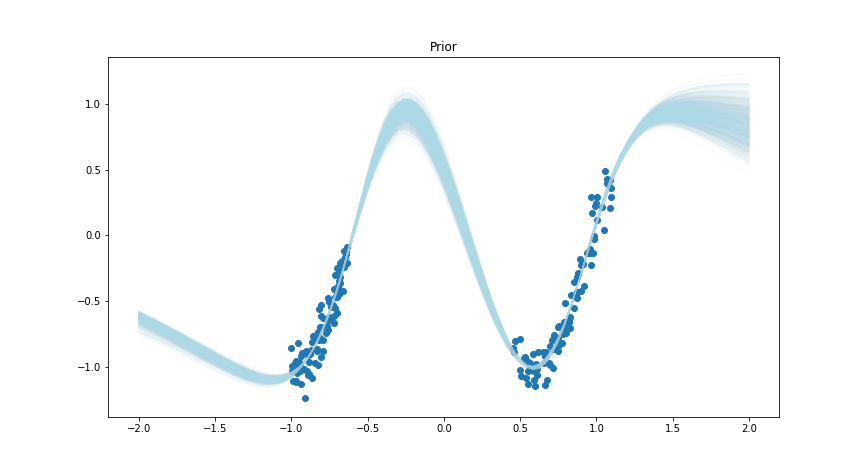

In [52]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook
import math

x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
#fig.set_size_inches(10, 10)
plt.title('Prior')


plt.scatter(x_data.cpu(), y_data.cpu())
for i in range(1000):
    theta = VAE.sample()
    set_all_parameters(model, theta)
    y_test = model(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')


In [46]:
n_samples_VAR = 200

In [50]:
VAE_optimizer = torch.optim.Adam(list(VAE.mfvar.parameters()) + list(VAE.nntransform.parameters()), lr=.005)
VAE_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(VAE_optimizer, patience=100, factor=0.5)

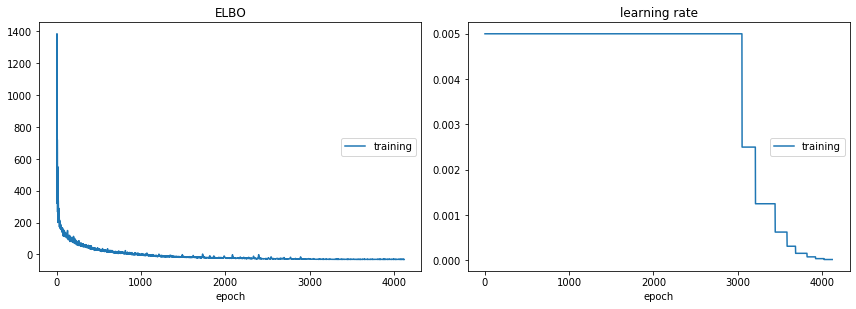

ELBO:
training   (min:  -31.465, max: 2136.679, cur:  -30.843)

learning rate:
training   (min:    0.000, max:    0.005, cur:    0.000)


In [51]:
%matplotlib inline

liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    VAE_optimizer.zero_grad()

    learning_rate = VAE_optimizer.param_groups[0]['lr']
     
    LL=torch.Tensor(n_samples_VAR)

    # Expected Log Likelihood
    for i in range(n_samples_VAR):
        theta = VAE.sample()
        LL[i]=logposterior(theta) 
    L = LL.mean()
    
    points = VAE.sample(100)
    M = pairwise_distances(points.detach().clone().numpy(), points.detach().clone().numpy())
    np.fill_diagonal(M, np.inf)
    idx = np.unravel_index(M.argmin(), M.shape)
    
    ELBO = -logprior(points[idx[0],:]) - L
    ELBO.backward()
    

    VAE_scheduler.step(ELBO.detach().clone().cpu().numpy())

    logs['ELBO'] = ELBO.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    #logs['memory'] = torch.cuda.memory_allocated(device=device)
    #logs['predictive likelihood'] = LL.detach().clone().cpu().numpy()
    liveloss.update(logs)

    if t % 10 == 0:
        liveloss.draw()

    #if t %2 == 0:
    VAE_optimizer.step()

    if learning_rate < 0.00001:
        break

# Résultats #

In [ ]:
(VAE.mfvar.mu,VAE.mfvar.sigma)

In [ ]:
for layer in VAE.decoder.modules():
    if isinstance(layer, nn.Linear):
        print(layer.weight)
        print(layer.bias)

In [ ]:
# aperçu de la distibution apprise sur les paramètres du modèle primaire.
# sampling of VAE 10 000 times and plotting a few 2D projections of the sampled parameters

import matplotlib.pyplot as plt
%matplotlib notebook

L = VAE(10000).detach().numpy()


fig, axs = plt.subplots(6, 4,figsize=(10,15))
for k in range(6):
    for l in range(4):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].scatter(L[:,i[0]],L[:,i[1]],marker='.',alpha=0.08,color='blue')
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()

## Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution ##


In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook

x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
#fig.set_size_inches(10, 10)
plt.scatter(x_data.cpu(), y_data.cpu(),marker='.')
for i in range(1000):
    theta=VAE()
    set_all_parameters(model, theta)
    y_test = model(x_test)    
#    plt.axis('scaled')
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')



In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook

x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
#fig.set_size_inches(10, 10)
plt.scatter(x_data.cpu(), y_data.cpu(),marker='.')
j=0
for i in range(1000):
    z=torch.Tensor(1,lat_dim)
    for k in range(lat_dim):
        if k==j:
            z[0,k]=VAE.mfvar.sample().detach().squeeze()[k]
        else:
            z[0,k]=VAE.mfvar.mu[k]
    theta=VAE.decoder(z)
    set_all_parameters(model, theta)
    y_test = model(x_test)    
#    plt.axis('scaled')
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')
plt.title('variation on dimension '+str(j)+' autour de mu')


# Calcul de l'évidence #

In [ ]:
n_samples=10000

prior=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(lat_dim), torch.eye(lat_dim))
E=torch.Tensor(n_samples)

for i in range(n_samples):
    z = prior.sample().unsqueeze(0)
    E[i]=logposterior(z)

evidence=E.logsumexp(0)-torch.log(torch.Tensor([n_samples]))

print('Log-évidence: '+str(evidence.squeeze().detach().numpy()))

In [ ]:
# estimation de l'évidence en utilisant la distribution apprise VAE.mfvar
E=torch.Tensor(n_samples)

for i in range(n_samples):
    z = VAE.mfvar.sample() 
    E[i]=logposterior(z)


print('Log-évidence estimée: '+str((E.logsumexp(0)-torch.log(torch.Tensor([n_samples]))).squeeze().detach().numpy())) 

In [ ]:
Div = KLDivGauss(VAE.mfvar.mu,VAE.mfvar.sigma)
    
LL=torch.Tensor(n_samples)

for i in range(n_samples):
    z = VAE.mfvar.sample()
    LL[i]=loglikelihood(z)

L = Div - LL.mean()


In [ ]:
L+evidence